In [52]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os

In [24]:
folder_path = '../data/Traffic_data'

dataframes = {}

for file in os.listdir(folder_path):
    if file.endswith('.traffic.htm'):
        file_path = os.path.join(folder_path, file)
        file_name = file.split('.')[0]
        df_list = pd.read_html(file_path)
        df = df_list[4]
        df = df.iloc[1:].reset_index(drop=True)
        df_key = file_name
        dataframes[df_key] = df

In [72]:
traffic_df = pd.read_csv('../data/traffic_df.csv', sep=',')

C:\Users\julia\AppData\Local\Temp\ipykernel_7048\2858799734.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('hsv', len(unique_road_names))


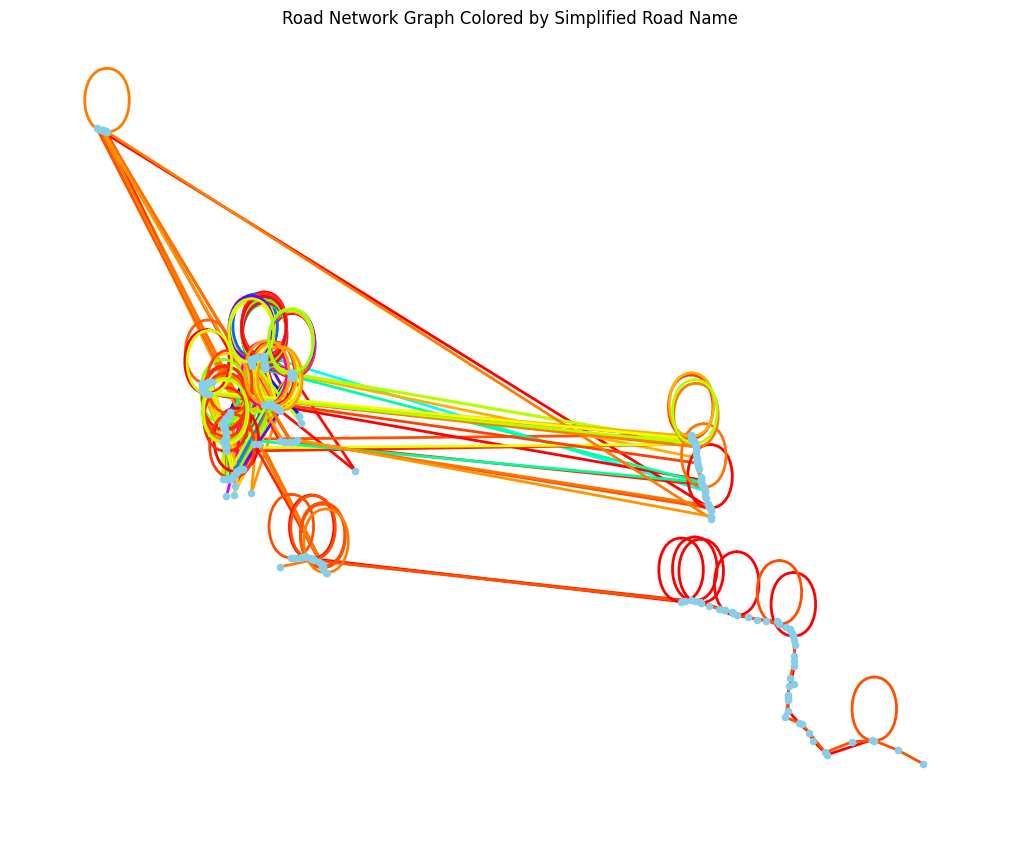

In [64]:
G = nx.Graph()

road_data['SimplifiedRoadName'] = road_data['Road'].apply(lambda x: x.split('-')[0].strip())

# Create a unique color for each simplified road name
unique_road_names = road_data['SimplifiedRoadName'].unique()
colors = plt.cm.get_cmap('hsv', len(unique_road_names))
road_name_to_color = {road: colors(i) for i, road in enumerate(unique_road_names)}

# Add edges to the graph, with the simplified road name as an attribute
for index, row in road_data.iterrows():
    start_node = row['LRP']
    end_node = row['LRP_2']
    length_km = row['(Km)']
    simplified_road_name = row['SimplifiedRoadName']  # Use the simplified road name
    if start_node in lrp_to_coords and end_node in lrp_to_coords:
        G.add_edge(start_node, end_node, length=length_km, road_name=simplified_road_name)

# Assign the position from lrp_to_coords
for node in G.nodes:
    if node in lrp_to_coords:
        G.nodes[node]['pos'] = lrp_to_coords[node]

# Visualization with edges colored by the simplified road name
plt.figure(figsize=(10, 8))
edge_colors = [road_name_to_color[G.edges[edge]['road_name']] for edge in G.edges()]

nx.draw(G, pos=lrp_to_coords, with_labels=False, node_size=20, font_size=8,
        node_color='skyblue', edge_color=edge_colors, width=2)
plt.title('Road Network Graph Colored by Simplified Road Name')
plt.show()

C:\Users\julia\AppData\Local\Temp\ipykernel_7048\534620213.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('hsv', len(unique_road_names))


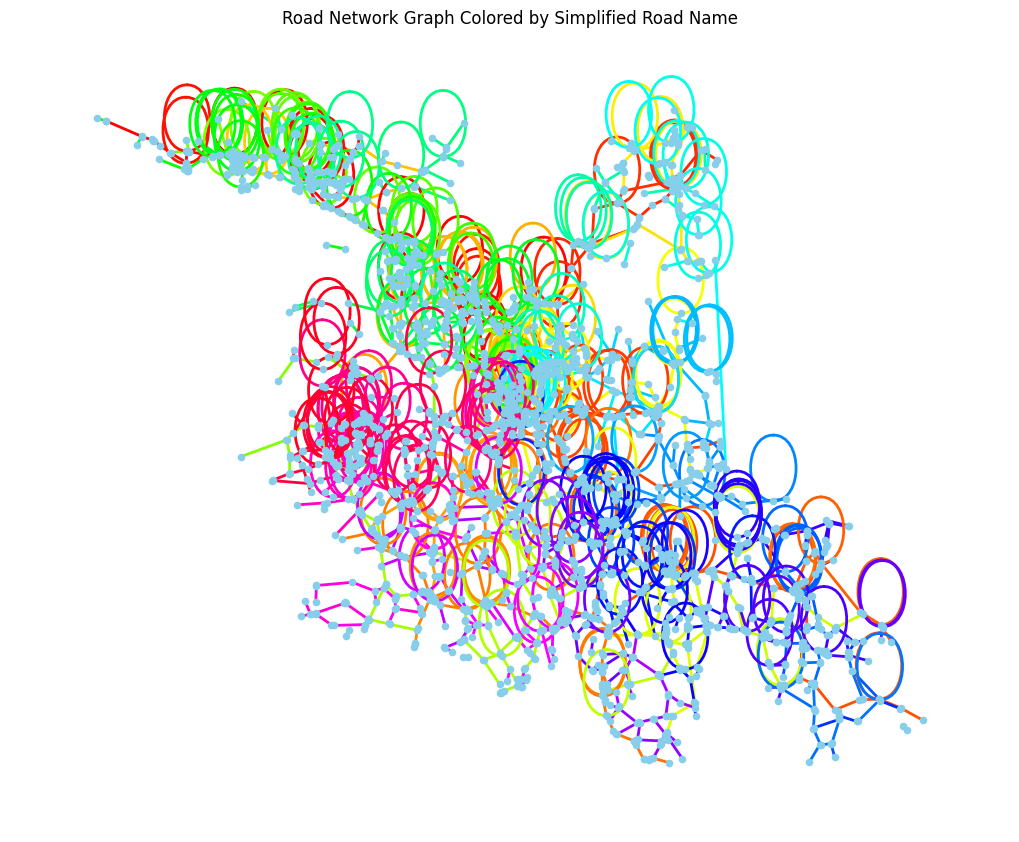

In [69]:
# Load the datasets
traffic_df = pd.read_csv('../data/traffic_df.csv')
roads_df = pd.read_csv('../data/_roads3.csv')

# Create simplified road names in the traffic dataset
traffic_df['SimplifiedRoadName'] = traffic_df['Road'].apply(lambda x: x.split('-')[0].strip())

# Create a unique identifier for each LRP that includes its road
traffic_df['LRP_Unique'] = traffic_df['SimplifiedRoadName'] + "_" + traffic_df['LRP']
traffic_df['LRP_2_Unique'] = traffic_df['SimplifiedRoadName'] + "_" + traffic_df['LRP_2']

# Assuming roads_df has 'lrp', 'lon', 'lat', and a road identifier that matches traffic_df['SimplifiedRoadName']
roads_df['LRP_Unique'] = roads_df['road'] + "_" + roads_df['lrp']  # Adjust 'Road' to the correct column name if different

# Create a dictionary to map LRP_Unique to coordinates
lrp_to_coords = {row['LRP_Unique']: (row['lat'], row['lon']) for index, row in roads_df.iterrows()}

# Initialize the graph
G = nx.Graph()

# Add edges to the graph, using the unique LRP identifiers to set positions
for index, row in traffic_df.iterrows():
    start_node = row['LRP_Unique']
    end_node = row['LRP_2_Unique']
    length_km = row['(Km)']  # Assuming this is the length column
    simplified_road_name = row['SimplifiedRoadName']
    # Check if both nodes have coordinates before adding the edge
    if start_node in lrp_to_coords and end_node in lrp_to_coords:
        G.add_edge(start_node, end_node, length=length_km, road_name=simplified_road_name)

# Assign coordinates to nodes in the graph
for node in G.nodes:
    if node in lrp_to_coords:
        G.nodes[node]['pos'] = lrp_to_coords[node]

# Create a unique color for each simplified road name
unique_road_names = traffic_df['SimplifiedRoadName'].unique()
colors = plt.cm.get_cmap('hsv', len(unique_road_names))
road_name_to_color = {road: colors(i) for i, road in enumerate(unique_road_names)}

# Visualization
plt.figure(figsize=(10, 8))
edge_colors = [road_name_to_color[G.edges[edge]['road_name']] for edge in G.edges() if 'road_name' in G.edges[edge]]

nx.draw(G, pos=lrp_to_coords, with_labels=False, node_size=20, font_size=8, node_color='skyblue', edge_color=edge_colors, width=2)
plt.title('Road Network Graph Colored by Simplified Road Name')
plt.show()

In [74]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import numpy as np

# Load the roads dataset
roads_df = pd.read_csv('../data/_roads3.csv')

# Assuming roads_df contains columns for 'road', 'lrp', 'chainage', 'lat', and 'lon'
# and that for each road, the LRPs are ordered by their chainage

# Simplify the road names
roads_df['SimplifiedRoadName'] = roads_df['road'].apply(lambda x: x.split('-')[0].strip())

# Group the data by road to process each road individually
grouped = roads_df.groupby('SimplifiedRoadName')

# Placeholder for node positions
node_positions = {}

# Process each road
for road_name, group in grouped:
    chainages = group['chainage'].values
    lats = group['lat'].values
    lons = group['lon'].values

    # Create interpolation functions for latitudes and longitudes
    lat_interp = interp1d(chainages, lats, kind='linear')
    lon_interp = interp1d(chainages, lons, kind='linear')

    # For simplicity, this example uses existing chainage values as nodes
    # For a more detailed approach, you'd interpolate between these points
    for chainage, lat, lon in zip(chainages, lats, lons):
        node = f"{road_name}_{chainage}"
        node_positions[node] = (lat_interp(chainage), lon_interp(chainage))

# At this point, node_positions contains nodes named with road and chainage,
# and their positions are set based on linear interpolation of the coordinates

# Now, you'd create and visualize the graph as before, using node_positions for layout

# Initialize the graph (assuming edges are added elsewhere in your code)
G = nx.Graph()

# Visualization using the interpolated positions
plt.figure(figsize=(10, 8))
nx.draw(G, pos=node_positions, with_labels=False, node_size=20, font_size=8, node_color='skyblue')
plt.title('Road Network Graph with Interpolated Positions')
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '../data/_roads3.csv'